# Exploratory notebook for miniblock decoding analysis
#### Plot decoding as a function of miniblock

In [157]:
import numpy as np
import scipy.stats as stats
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import pandas as pd
import loadTaskBehavioralData as task
import tools
import multiprocessing as mp
import statsmodels.stats.multitest as mc
%matplotlib inline

#### Parameter set up

In [196]:
projectdir = '/projects3/CPROCompositionality/'
datadir = projectdir + 'data/processedData/' 
resultdir = projectdir + 'data/results/'
subjNums = ['013','014','016','017','018','021','023','024','026','027','028',
            '030','031','032','033','034','035','037','038','039','040','041',
            '042','043','045','046','047','048','049','050','053','055','056',
            '057','058','062','063','066','067','068','069','070','072','074',
            '075','076','077','081','085','086','087','088','090','092','093',
            '094','095','097','098','099','101','102','103','104','105','106',
            '108','109','110','111','112','114','115','117','119','120','121',
            '122','123','124','125','126','127','128','129','130','131','132',
            '134','135','136','137','138','139','140','141']

glasser = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = nib.load(glasser).get_data()
glasser = np.squeeze(glasser)
rois = np.arange(1,361)

#### Load in CAB-NP ROI labels
cabn_labels = pd.read_csv(projectdir + 'data/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt',header=0,delimiter='\t')
df_labels = cabn_labels.iloc[0:360]
df_labels.reset_index()
del df_labels['INDEX'], df_labels["KEYVALUE"]

# Using final partition
networkdef = df_labels['NETWORKKEY'].values
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}

In [187]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Run novelty decoding to identify relevant regions

In [176]:
df_novelty = pd.read_csv(resultdir + 'CrossSubjectNoveltyDecoding/CrossSubjectNoveltyDecoding_allROIs.csv')
chance = 0.5
rois = np.unique(df_novelty.ROI)
accuracy = []
ps = []
for roi in np.sort(rois):
    tmp_df = df_novelty.loc[df_novelty.ROI==roi]
    acc = tmp_df.DecodingAccuracy.values
    p = stats.binom_test(np.mean(acc),n=len(acc),p=chance)
    p = p/2.0 if np.mean(acc)>chance else 1.0-p/2.0
    ps.append(p)
    accuracy.append(np.mean(acc))

novelty_regions = mc.fdrcorrection(ps)[0]


#### Identify the novelty regions that also have significant decoding of task set information 

In [197]:
rois = np.arange(1,361)
chance = 1/64.0
accuracy = []
ps = []
for roi in np.sort(rois):
    df_64 = pd.read_csv(resultdir + 'CrossSubject64TaskDecoding/CrossSubject64TaskDecoding_roi' + str(roi) + '.csv')
    subjs = np.unique(df_64.Subject.values)
    subjaccuracy = []
    for subj in subjs:
        tmpdf = df_64.loc[df_64.Subject==subj]
        acc = np.mean(tmpdf.DecodingAccuracy.values)
        subjaccuracy.append(acc)
    t, p = stats.ttest_1samp(subjaccuracy,chance)
    p = p/2.0 if np.mean(subjaccuracy)>chance else 1.0-p/2.0
    ps.append(p)
    accuracy.append(np.mean(subjaccuracy))

task64_regions = mc.fdrcorrection(ps)[0]

#### intersection
regions_interest = np.multiply(task64_regions,novelty_regions)
regions_interest = np.where(regions_interest)[0]

#### Compute decoding accuracy for each miniblock

In [286]:
rois = np.arange(1,361)
chance = 1/64.0
mb_acc = np.zeros((360,128))
df_plot = {}
df_plot['ROI'] = []
df_plot['Accuracy'] = []
df_plot['Miniblock'] = []
roi_ind = np.where(networkdef==networkmappings['vis1'])[0]
for roi in roi_ind:
    df_64 = pd.read_csv(resultdir + 'CrossSubject64TaskDecoding/CrossSubject64TaskDecoding_roi' + str(roi+1) + '.csv')
    mbs = np.unique(df_64.Miniblock.values)
    for mb in mbs:
        tmpdf = df_64.loc[df_64.Miniblock==mb]
        acc = np.mean(tmpdf.DecodingAccuracy.values)
        df_plot['ROI'].append(roi)
        df_plot['Accuracy'].append(acc)
        df_plot['Miniblock'].append(mb)

df_plot = pd.DataFrame(df_plot)

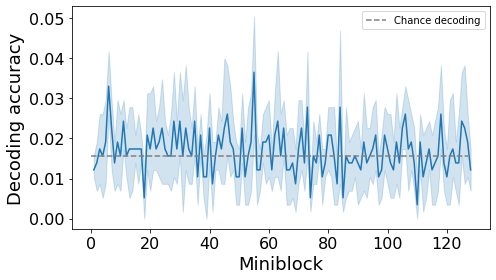

In [287]:
plt.figure(figsize=(7,4))
sns.lineplot(x="Miniblock", y="Accuracy", data=df_plot)
plt.plot(np.arange(128),np.repeat(chance,128),'gray',linestyle='--',label='Chance decoding')
#plt.title('ROI:' + str(roi)+ '| Network:' + str(networkdef[roi]),fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Miniblock',fontsize=18)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.legend()
plt.tight_layout()

#### Load results for logic rule decoding

In [238]:
rois = np.arange(1,361)
chance = 1/4.0
rule_accuracy = {}
ps = []
for roi in np.sort(rois):
    rule_accuracy[roi] = {}
    df_logic = pd.read_csv(resultdir + 'CrossSubjectLogicRuleDecoding/CrossSubjectLogicRuleDecoding_roi' + str(roi) + '.csv')
    rules = np.unique(df_logic.LogicRules.values)
    subjs = np.unique(df_logic.Subject.values)
    for rule in rules:
        ruledf = df_logic.loc[df_logic.LogicRules==rule]
        tmprulesubj_acc = []
        for subj in subjs:
            tmpdf = ruledf.loc[ruledf.Subject==subj]
            tmprulesubj_acc.append(tmpdf.DecodingAccuracy.values)
        rule_accuracy[roi][rule] = np.mean(np.asarray(tmprulesubj_acc),axis=0)


#### Identify the logic rule regions that also have sensitivity to novelty 

In [295]:
acc

0.2265625

In [297]:
df_logic.keys()

Index(['Unnamed: 0', 'ROI', 'DecodingAccuracy', 'Miniblock', 'Subject',
       'LogicRules', 'SensoryRules', 'MotorRules', 'TaskNovelty', 'TaskID',
       'TaskPerformance'],
      dtype='object')

In [319]:
np.asarray(subj_mb_data).shape

(96, 32)

In [328]:
chance = 1/4.0
accuracy = []
ps = []
df_plot = {}
df_plot['ROI'] = []
df_plot['Rule'] = []
df_plot['Accuracy'] = []
df_plot['Block'] = []
roi_ind = np.where(networkdef==networkmappings['vis2'])[0]
for roi in roi_ind:
    df_logic = pd.read_csv(resultdir + 'CrossSubjectLogicRuleDecoding/CrossSubjectLogicRuleDecoding_roi' + str(roi+1) + '.csv')
    rules = np.unique(df_logic.LogicRules.values)
    for rule in rules:
        tmpdf = df_logic.loc[df_logic.LogicRules==rule]
        subj_mb_data = []
        for subj in np.unique(tmpdf.Subject.values):
            tmpdf2 = tmpdf.loc[tmpdf.Subject==subj]
            subj_mb_data.append(tmpdf2.DecodingAccuracy.values)
        subj_mb_data = np.asarray(subj_mb_data) # subject x miniblock (per rule) data
        
        mbcount = 1
        for mb in range(subj_mb_data.shape[1]):
            df_plot['Block'].append(mbcount)
            df_plot['Accuracy'].append(np.mean(subj_mb_data[:,mb]))
            df_plot['Rule'].append(rule)
            df_plot['ROI'].append(roi)
            mbcount += 1
#     subjs = np.unique(df_logic.Subject.values)
#     subjaccuracy = []
#     for subj in subjs:
#         tmpdf = df_logic.loc[df_logic.Subject==subj]
#         acc = np.mean(tmpdf.DecodingAccuracy.values)
#         subjaccuracy.append(acc)
    
#     t, p = stats.ttest_1samp(subjaccuracy,chance)
#     p = p/2.0 if np.mean(subjaccuracy)>chance else 1.0-p/2.0
#     ps.append(p)
#     accuracy.append(np.mean(subjaccuracy))

# logic_regions = np.where(mc.fdrcorrection(ps)[0])[0]

#### intersection
# regions_interest = np.multiply(logic_regions,novelty_regions)
# fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
# con_ind = np.where(networkdef==networkmappings['con'])[0]
# net_ind = np.hstack((fpn_ind,con_ind))
# regions_interest = np.intersect1d(fpn_ind,logic_regions)

df_plot = pd.DataFrame(df_plot)

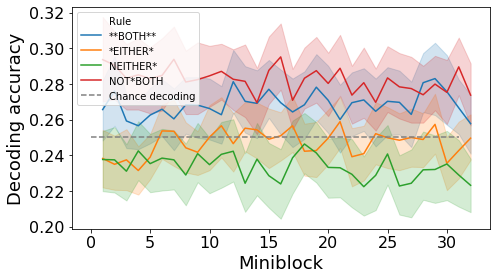

In [329]:
df_plot = pd.DataFrame(df_plot)
plt.figure(figsize=(7,4))
sns.lineplot(x="Block", y="Accuracy", hue="Rule",data=df_plot)
num_mbs = len(np.unique(df_plot.Block.values))
plt.plot(np.arange(num_mbs),np.repeat(chance,num_mbs),'gray',linestyle='--',label='Chance decoding')
#plt.title('ROI:' + str(roi)+ '| Network:' + str(networkdef[roi]),fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Miniblock',fontsize=18)
plt.ylabel('Decoding accuracy',fontsize=18)
plt.legend()
plt.tight_layout()

/home/tito/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


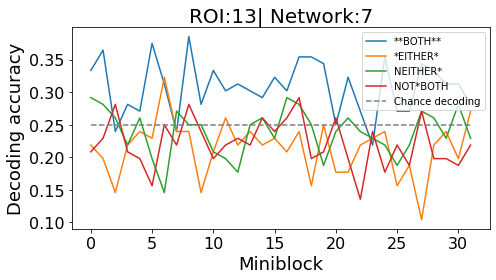

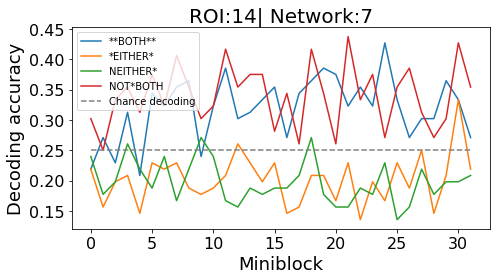

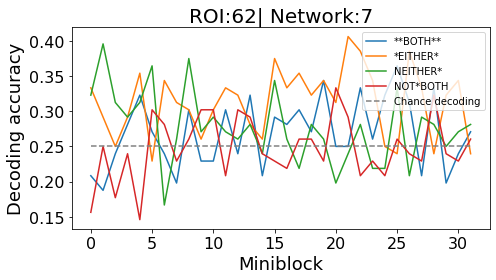

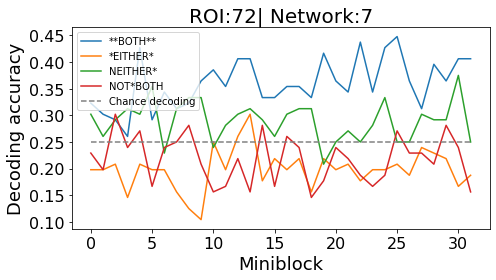

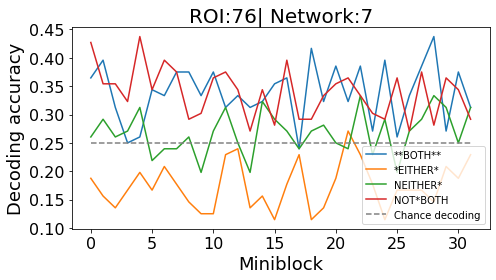

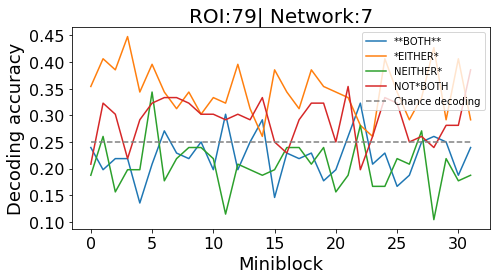

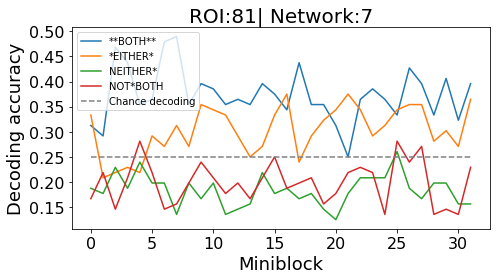

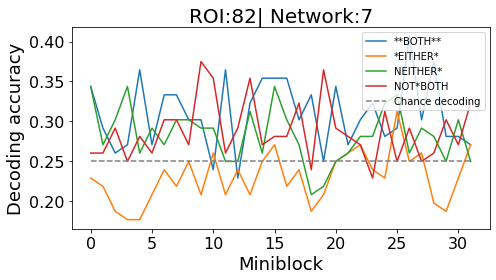

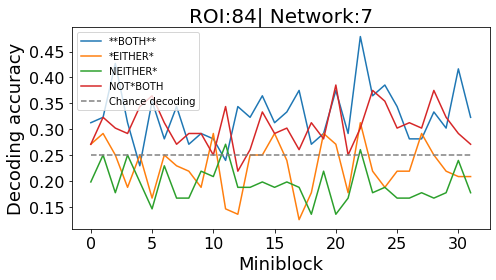

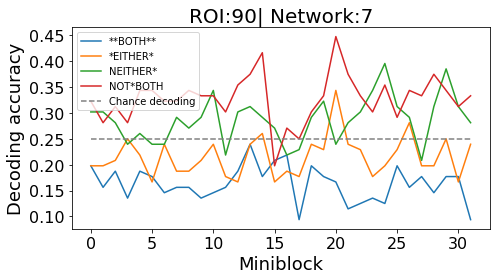

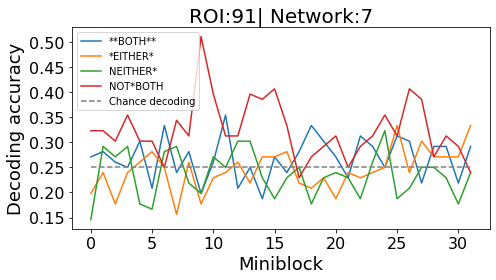

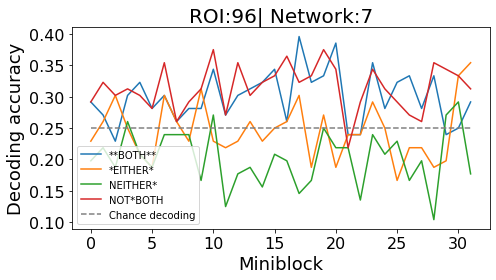

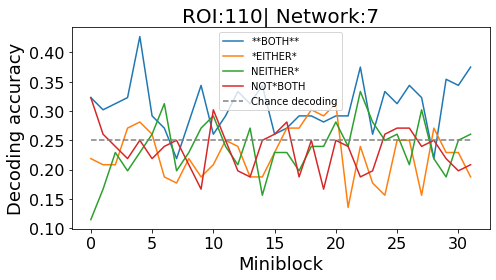

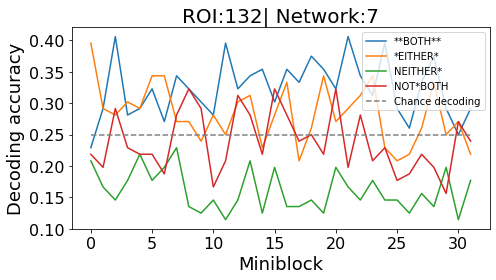

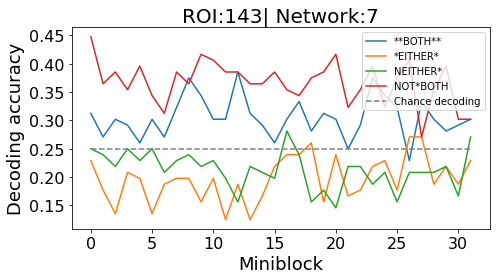

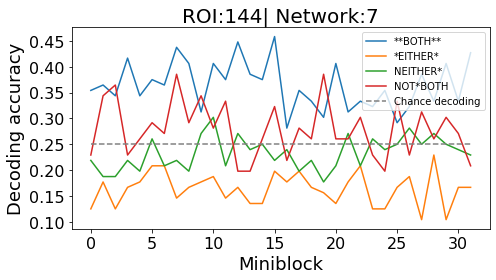

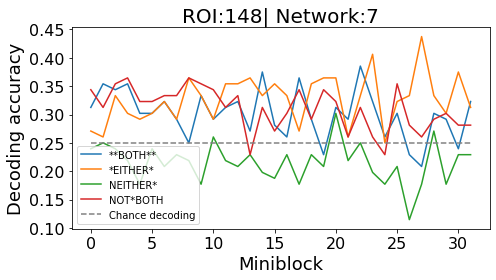

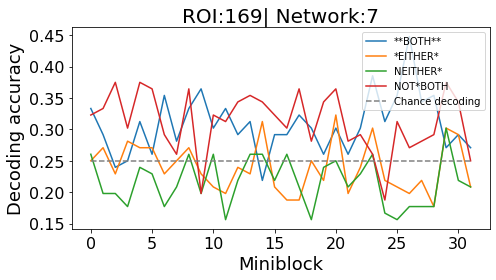

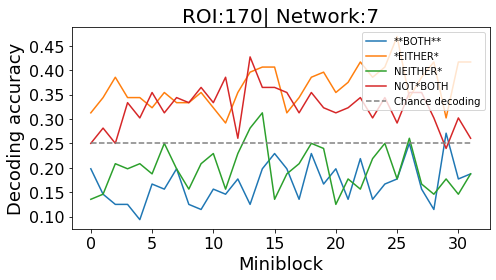

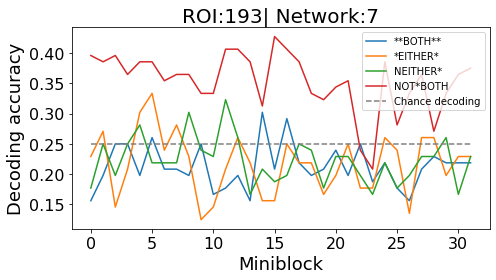

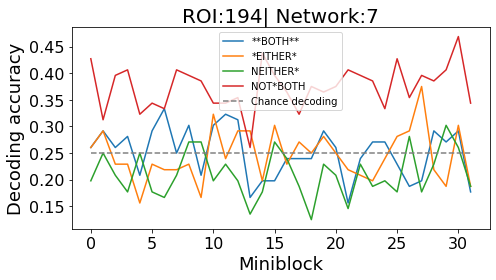

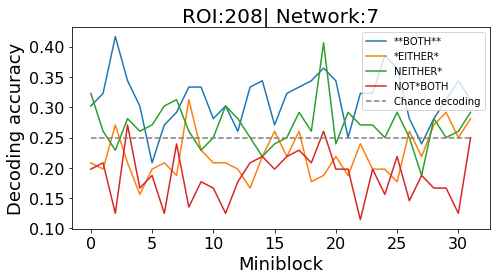

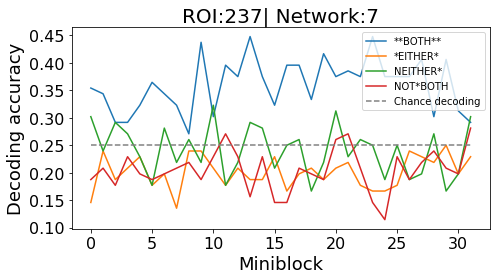

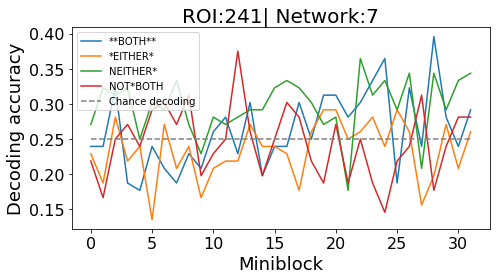

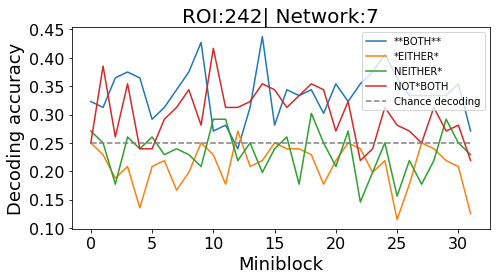

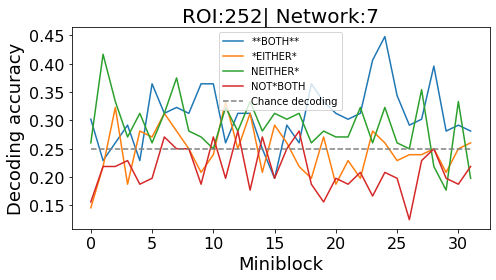

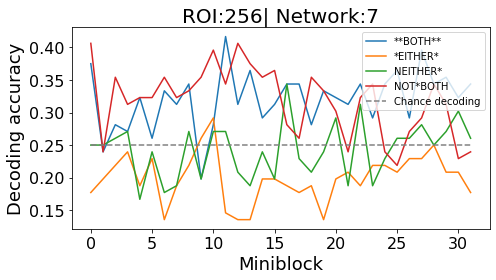

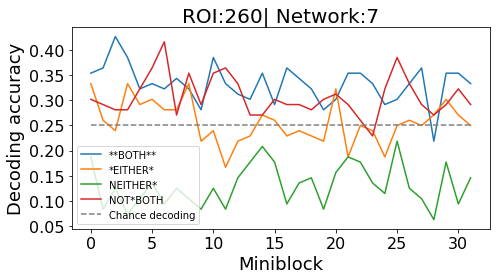

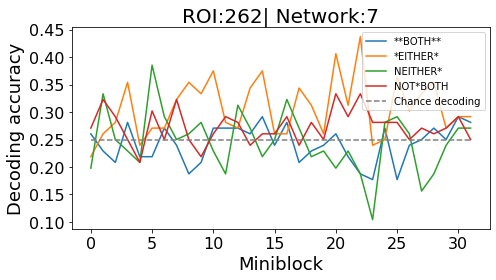

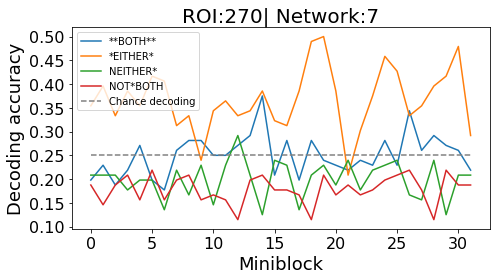

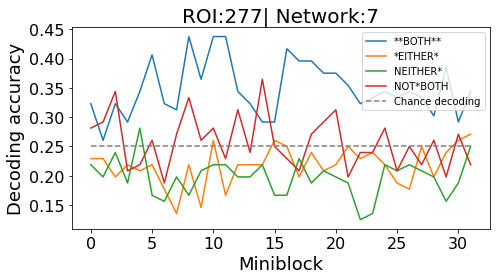

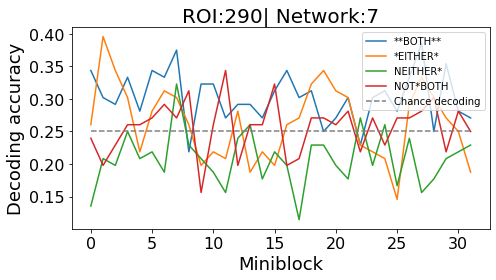

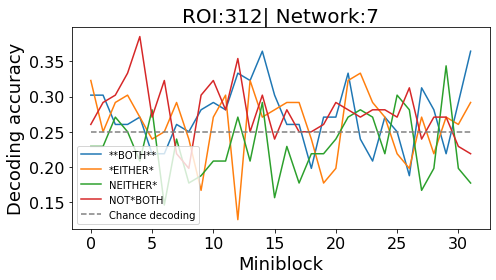

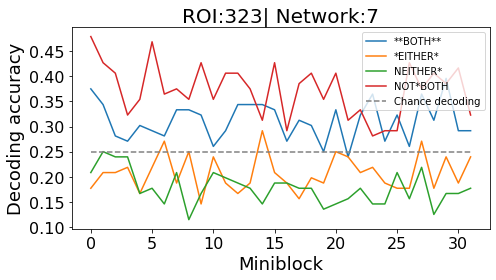

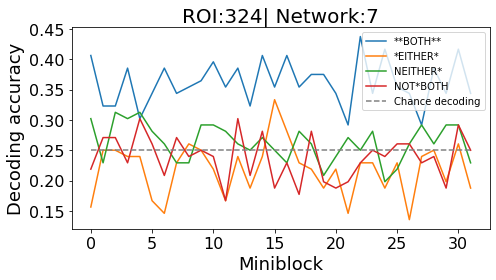

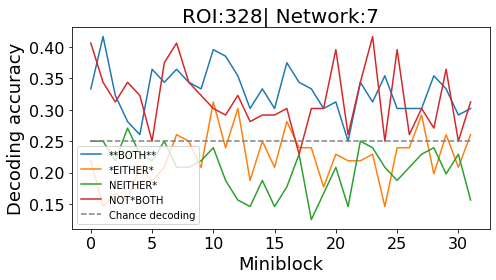

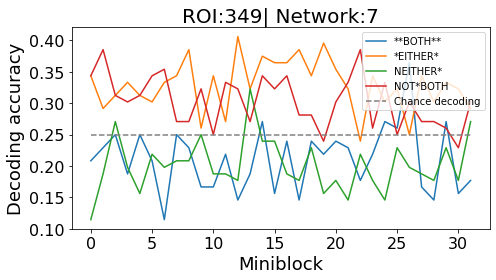

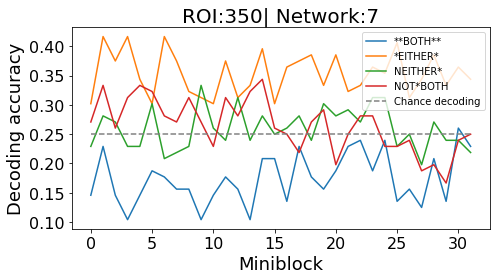

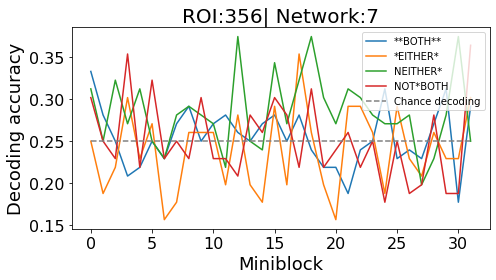

In [247]:
for roi in regions_interest:
    plt.figure(figsize=(7,4))
    for rule in rule_accuracy[roi]:
        #plt.plot(moving_average(rule_accuracy[roi][rule],n=10),label=rule)
        plt.plot(rule_accuracy[roi][rule],label=rule)
    plt.plot(np.arange(len(rule_accuracy[roi][rule])),np.repeat(chance,len(rule_accuracy[roi][rule])),'gray',linestyle='--',label='Chance decoding')
    plt.title('ROI:' + str(roi)+ '| Network:' + str(networkdef[roi]),fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Miniblock',fontsize=18)
    plt.ylabel('Decoding accuracy',fontsize=18)
    plt.legend()
    plt.tight_layout()